In [ ]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

SNAPSHOT_DATE = "24_aug"

json_file = Path('prod_snapshot/schemes-prod-firestore-structure.json')
output_dir = Path(f'figures/{SNAPSHOT_DATE}')
os.makedirs(output_dir, exist_ok=True)

plt.rcParams['font.family'] = 'monospace'

In [2]:
with open(json_file, 'rb') as f:
    data = json.load(f)

    schemes = data['schemes']['documents']
    user_queries = data['userQuery']['documents']
    chat_history = data['chatHistory']['documents']

In [3]:
# Filter user_queries and chat_history to only after update

query_ts_format_str = "%a, %d %b %Y %H:%M:%S %Z"
chat_ts_format_str = "%Y-%m-%d %H:%M:%S %Z"

def filter_new(user_queries: list[dict], chat_history: list[dict]) -> tuple[list[dict], list[dict]]:
    filtered_queries = []
    new, old, no_res = [], [], []
    for query in user_queries:
        x = query['data']['schemes_response']
        if (not x):
            no_res.append(query)
            continue

        ts_str = query['data']['query_timestamp']
        dt_object = datetime.strptime(ts_str, query_ts_format_str)

        if ('scheme' in x[0]):
            new.append(dt_object)
            filtered_queries.append(query)
        else: 
            old.append(dt_object)

    new.sort()
    old.sort()

    filtered_chat = []
    for chat_hist in chat_history:
        ts_str = chat_hist['data']['last_updated']
        if (datetime.strptime(ts_str, chat_ts_format_str) < old[-1]): continue

        filtered_chat.append(chat_hist)

    return filtered_queries, filtered_chat
        
user_queries, chat_history = filter_new(user_queries, chat_history)

In [4]:
from collections import Counter
import heapq


# scheme_type = Counter()
# scheme_count = Counter()
# agency_count = Counter()

scheme_collator = []
# {
#     "dt": str,
#     "agency": str,
#     "scheme": str,
# }

scheme_type_collator = []
# {
#     "dt": str,
#     "type": str
# }

query_type_collator = []
# {
#     "dt": str,
#     "type": str
# }

NUM_CATEGORIES_PER_QUERY = 1
# query_count_by_scheme_type = Counter()

def get_keys(new: bool) -> tuple[str, str, str, str]:
    return ('scheme', 'scheme_type', 'agency', 'Similarity') if new else ('Scheme', 'Scheme Type', 'Agency', 'Similarity')

for query in user_queries:
    query_scheme_type = Counter()
    dt = datetime.strptime(query['data']['query_timestamp'], query_ts_format_str)

    for scheme in query['data']['schemes_response']:
        is_new = 'scheme' in scheme
        scheme_name_key, scheme_type_key, scheme_agency_key, sim_key = get_keys(is_new)
        # scheme_count[scheme[scheme_name_key]] += 1

        scheme_collator.append({
            "dt": dt,
            "agency": scheme[scheme_agency_key],
            "scheme": scheme[scheme_name_key]
        })

        scheme_types = [x.lower().strip() for x in scheme[scheme_type_key].split(',')] if isinstance(scheme[scheme_type_key], str) else []
        for scheme_type_cat in scheme_types:
            # scheme_type[scheme_type_cat] += 1
            scheme_type_collator.append({
                "dt": dt,
                "type": scheme_type_cat
            })

            query_scheme_type[scheme_type_cat] += scheme[sim_key]

        # agency_count[scheme[scheme_agency_key]] += 1

    
    query_scheme_type_sorted = heapq.nlargest(NUM_CATEGORIES_PER_QUERY, query_scheme_type.items(), key=lambda x: x[1])
    for s_t, _ in query_scheme_type_sorted:
        # query_count_by_scheme_type[s_t] += 1
        query_type_collator.append({
            "dt": dt,
            "type": s_t
        })

scheme_df = pd.DataFrame(scheme_collator)
scheme_type_df = pd.DataFrame(scheme_type_collator)
query_type_df = pd.DataFrame(query_type_collator)

In [5]:
# For formatting labels (alignment, wrapping text)

def wrap_label(text: str, limit: int = 20, align_left: bool = True) -> str: 
    if len(text) < limit: return text
    
    words = text.split(' ')
    line_letter_count = 0
    max_line_letter_count = 0
    new_lines = []
    new_text_line = ''
    for word in words:
        if len(word) + line_letter_count < limit:
            new_text_line += word + ' '
            line_letter_count += len(word) + 1
            continue

        new_lines.append(new_text_line)
        max_line_letter_count = max(max_line_letter_count, line_letter_count)
        new_text_line = word + ' '
        line_letter_count = len(word) + 1

    new_lines.append(new_text_line)
    max_line_letter_count = max(max_line_letter_count, line_letter_count)

    if align_left:
        for i in range(len(new_lines)):
            new_lines[i] += (max_line_letter_count - len(new_lines[i])) * ' '
            
    return '\n'.join(new_lines)

### Recommended Schemes 

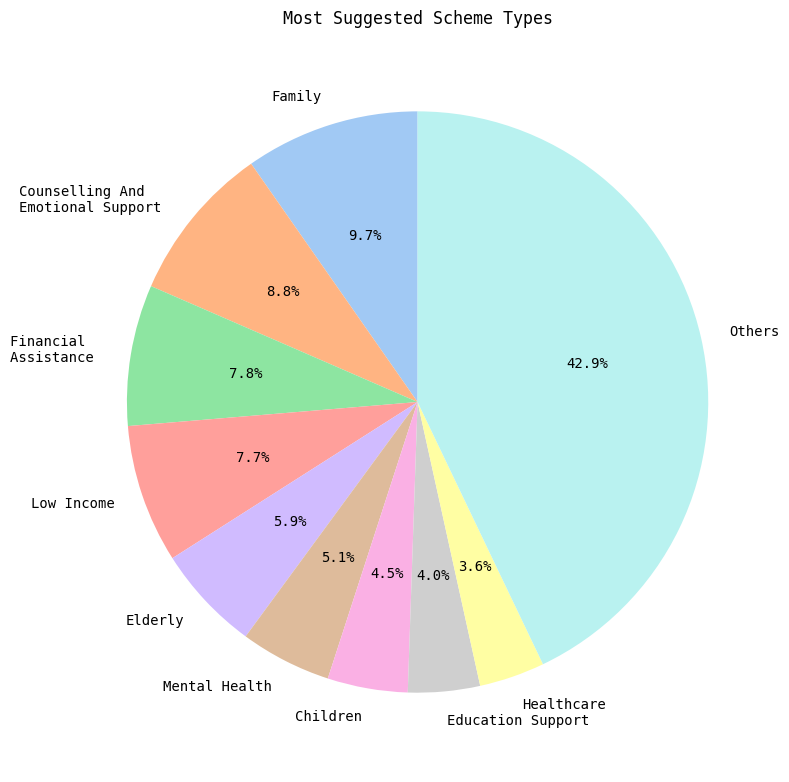

In [7]:
# Most common recommended scheme categories

TOP_N = 9

# sorted_cats = sorted(scheme_type.items(), key = lambda x: x[1], reverse=True)

# topn = sorted_cats[:TOP_N]
# sum_others = sum([x[1] for x in sorted_cats[TOP_N:]])

# labels = [x[0].title() for x in topn] + ['Others']
# sizes = [x[1] for x in topn] + [sum_others]

agg_df = scheme_type_df.groupby('type').size().reset_index(name='count').sort_values('count', ascending=False)

labels = agg_df['type'].head(TOP_N).to_list() + ['others']
sizes = agg_df['count'].head(TOP_N).to_list() + [agg_df.iloc[TOP_N:]['count'].sum()]

colors = sns.color_palette('pastel')

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[wrap_label(label.title()) for label in labels], colors=colors, autopct='%1.1f%%', startangle=90)

plt.axis('equal')
plt.title('Most Suggested Scheme Types')
plt.tight_layout()

fig_fp = output_dir / 'types_piechart.jpg'
plt.savefig(fig_fp)
plt.show()

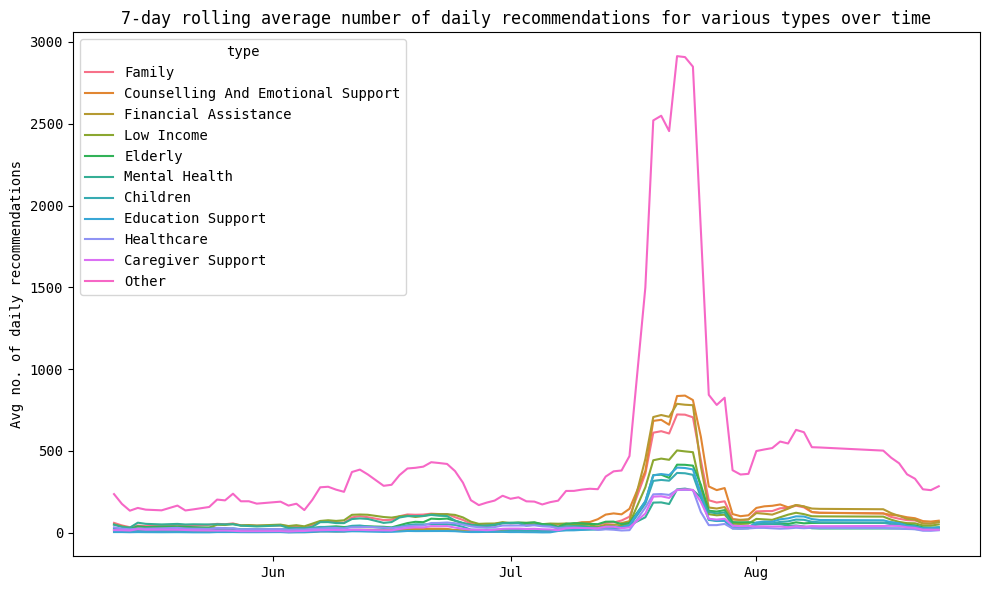

In [60]:
# Suggestions of category types over time

grouped = scheme_type_df.groupby([scheme_type_df['dt'].dt.date, 'type']).size().reset_index(name='daily_count')
grouped = grouped.rename(columns={'dt': 'date'})

# Convert to wide format
pivot_grouped = grouped.pivot(index='date', columns='type', values='daily_count').fillna(0)

column_sums = pivot_grouped.sum().sort_values(ascending=False)
top_categories = column_sums.head(TOP_N).index.tolist()

condensed = pivot_grouped[top_categories].copy()
other_categories = [col for col in pivot_grouped.columns if col not in top_categories]
condensed['Other'] = pivot_grouped[other_categories].sum(axis=1)

rolling = condensed.rolling(window=7, min_periods = 1).mean()

# Convert back to long format for plotting
rolling_long = rolling.reset_index().melt(id_vars='date', var_name='type', value_name='rolling')
rolling_long['type'] = rolling_long['type'].str.title()

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = rolling_long, x='date', y='rolling', hue='type')

ax.set_title('7-day rolling average number of daily recommendations for various types over time')
ax.set_ylabel('Avg no. of daily recommendations')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'scheme_types_over_time.jpg'
plt.savefig(fig_fp)
plt.show()

### Recommended Queries

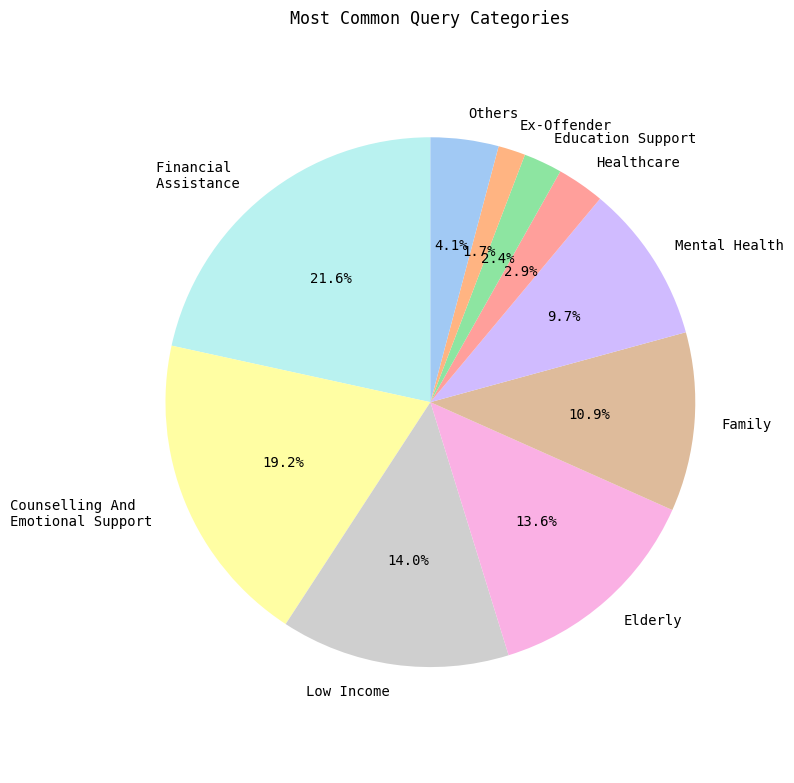

In [8]:
# Most common categories for queries (i.e. what are users asking), using scheme categories as proxy
# Proxy works by:
# 1. Collating all the categories of the recommended schemes for a query, 
# 2. Weighing them by the similarity score
# 3. Classify the query based on the categories which appear in the highest frequencies (how many can be determined by NUM_CATEGORIES_PER_QUERY)

TOP_N = 9

# sorted_cats = sorted(query_count_by_scheme_type.items(), key = lambda x: x[1], reverse=True)

# topn = sorted_cats[:TOP_N]
# sum_others = sum([x[1] for x in sorted_cats[TOP_N:]])

# labels = [x[0].title() for x in topn] + ['Others']
# sizes = [x[1] for x in topn] + [sum_others]

agg_df = query_type_df.groupby('type').size().reset_index(name='count').sort_values('count', ascending=False)

labels = agg_df['type'].head(TOP_N).to_list() + ['others']
sizes = agg_df['count'].head(TOP_N).to_list() + [agg_df.iloc[TOP_N:]['count'].sum()]

colors = sns.color_palette('pastel')[::-1]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[wrap_label(label.title()) for label in labels], colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Most Common Query Categories')
plt.tight_layout()

fig_fp = output_dir / 'query_types_piechart.jpg'
plt.savefig(fig_fp)
plt.show()

### Recommended Agencies

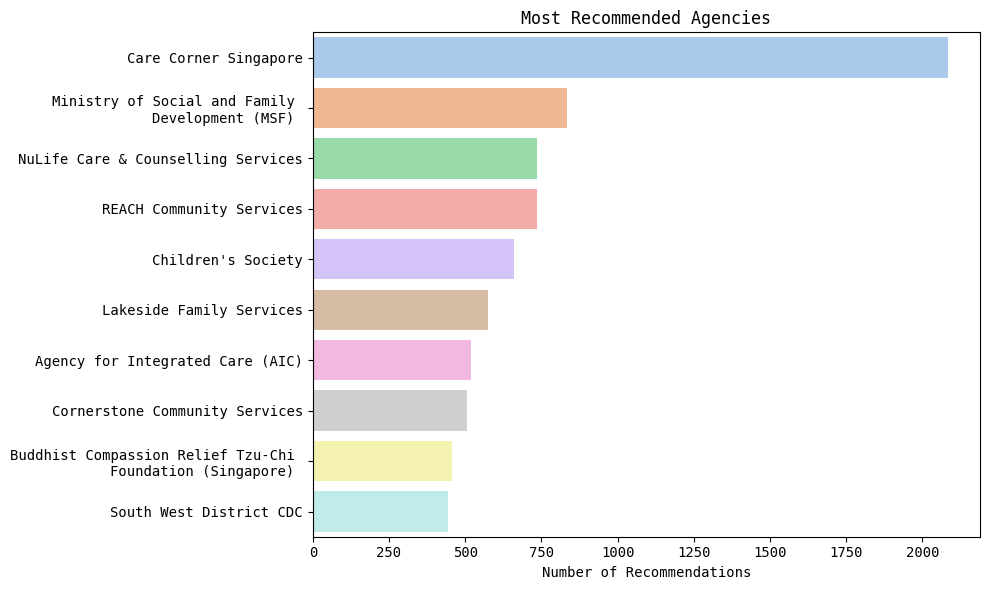

In [9]:
# Most recommended agencies

TOP_N = 10

num_queries = len(user_queries)
# sorted_agencies = sorted(agency_count.items(), reverse=True, key=lambda x: x[1])[:TOP_N]

# barplot_data = {
#     "Agencies": [wrap_label(x[0], limit = 35, align_left=False) for x in sorted_agencies],
#     "Recommendations": [x[1] for x in sorted_agencies]
# }

top_n_df = scheme_df.groupby('agency').size().reset_index(name='count').sort_values('count', ascending=False).head(TOP_N)
top_n_df['agency'] = top_n_df['agency'].apply(wrap_label, args=(35, False))
barplot_data = {
    "Agencies": top_n_df['agency'].to_list(),
    "Recommendations": top_n_df['count'].to_list()
}

plt.figure(figsize=(10, 6))

ax = sns.barplot(y=barplot_data["Agencies"], x=barplot_data["Recommendations"], hue=barplot_data["Agencies"], orient='y', palette=sns.color_palette('pastel'))

ax.set_title('Most Recommended Agencies')
ax.set_xlabel('Number of Recommendations')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(
    ax.get_yticklabels(),
    ha='right',
    fontsize=10
)

plt.tight_layout()

fig_fp = output_dir / 'agencies.jpg'
plt.savefig(fig_fp)
plt.show()

### Others

In [10]:
# Number of user queries and chat sessions

print(f"No. of User Queries:\t{len(user_queries)}")
print(f"No. of Chat Sessions:\t{len(chat_history)}")

No. of User Queries:	723
No. of Chat Sessions:	307


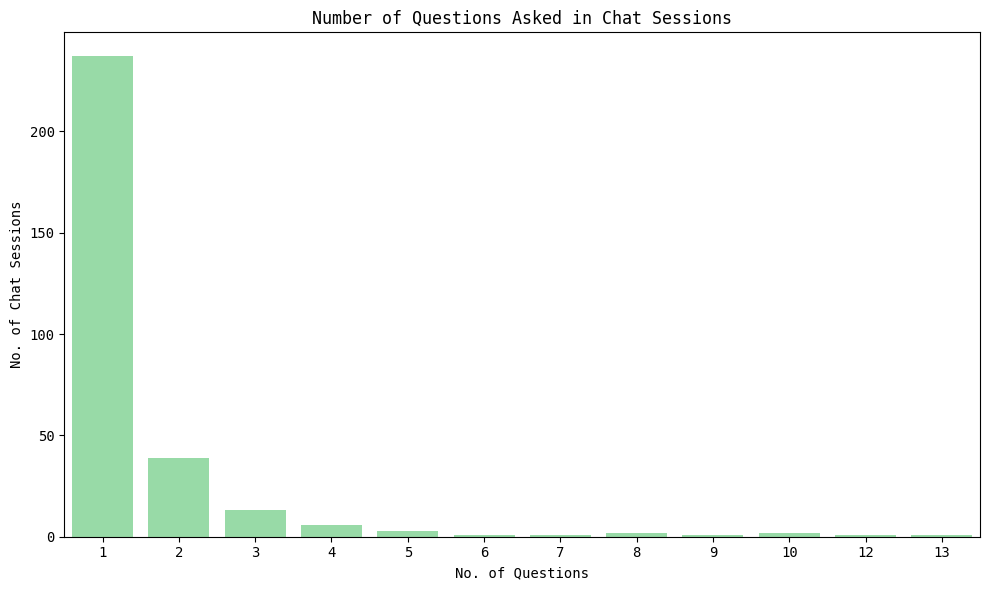

In [11]:
# Number of questions asked in Chat Sessions

num_messages = [len(chat_session['data']['messages']) for chat_session in chat_history]
num_questions = sorted([(num-1)//2 for num in num_messages])


plt.figure(figsize=(10, 6))

ax = sns.countplot(x=num_questions, color=sns.color_palette('pastel')[2])

ax.set_title('Number of Questions Asked in Chat Sessions')
ax.set_xlabel('No. of Questions')
ax.set_ylabel('No. of Chat Sessions')

plt.tight_layout()

fig_fp = output_dir / 'num_questions.jpg'
plt.savefig(fig_fp)
plt.show()

In [12]:
# For closer look into chat conversations with more questions

longer_conversations = [chat_session['data']['messages'] for chat_session in chat_history if (len(chat_session['data']['messages'])-1)/2 > 5]
with open('long_conv.json', 'w') as f:
    json.dump(longer_conversations, f, indent=4)

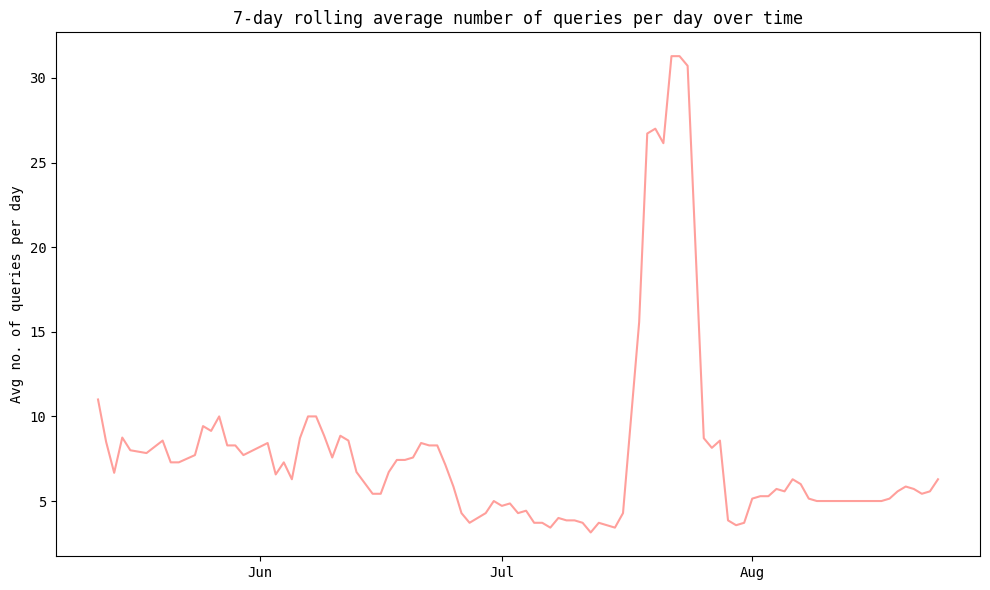

In [13]:
# No. of queries per day over time

dates = [datetime.strptime(query['data']['query_timestamp'], query_ts_format_str) for query in user_queries if query['data']['query_timestamp']]
dates_df = pd.DataFrame({'timestamps': dates})
grouped = dates_df.groupby(dates_df['timestamps'].dt.date).agg(count=('timestamps', 'count'))
grouped['rolling'] = grouped['count'].rolling(window=7, min_periods = 1).mean()
grouped['date'] = pd.to_datetime(grouped.index)

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = grouped, x='date', y='rolling', color=sns.color_palette('pastel')[3])

ax.set_title('7-day rolling average number of queries per day over time')
ax.set_ylabel('Avg no. of queries per day')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'num_queries_over_time.jpg'
plt.savefig(fig_fp)
plt.show()